<a href="https://colab.research.google.com/github/VernonNaidoo-Toronto/Understanding-Toronto-Shelters/blob/master/WA_CPI_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import numpy as np
import pandas as pd
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import sklearn
import scipy, scipy.stats
import statsmodels.formula.api as sm
from statsmodels.graphics.regressionplots import plot_regress_exog, plot_fit, plot_leverage_resid2, influence_plot
import warnings
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'

In [7]:
# Take a random sample of x records from DataFrame y:
def sample(df,number_of_records):
  display(df.loc[np.random.choice(len(df),number_of_records),:])
  #print('DataFrame has length',len(df), 'and shape',df.shape,'.')
  print(f'Random sample of {number_of_records} rows from DataFrame with {df.shape[0]} records and {df.shape[1]} columns.')

In [8]:
path1 = 'https://raw.githubusercontent.com/VernonNaidoo-Toronto/Understanding-Toronto-Shelters/master/Shelter%20Data/'

dso2017 = pd.read_csv(path1 + 'daily-shelter-occupancy-2017-csv.csv', 
                    parse_dates=['OCCUPANCY_DATE']); dso2017['source_file']=2017
dso2018 = pd.read_csv(path1 + 'daily-shelter-occupancy-2018-csv.csv',
                    parse_dates=['OCCUPANCY_DATE']); dso2018['source_file']=2018
dso2019 = pd.read_csv(path1 + 'daily-shelter-occupancy-2019-csv.csv',
                    parse_dates=['OCCUPANCY_DATE']); dso2019['source_file']=2019

# Get summary of records loaded
for year, df in [[2017,dso2017], [2018,dso2018], [2019,dso2019]]:
  print(f'Loaded {len(df)} records from the {year} file.')

cpi_data = pd.read_csv(path1 + 'CPI_MONTHLY.csv', header=20, names=['date', 'CPI', 'CPI_adj', 'Static', 'CPI_TRIM', 
                                                      'CPI_MEDIAN', 'CPI_COMMON', 'ATOM', 'CPIXFET', 'CPIW'])

Loaded 38700 records from the 2017 file.
Loaded 37770 records from the 2018 file.
Loaded 39446 records from the 2019 file.


In [9]:
# Concatenate DataFrames
daily_shelter_occupancy = pd.concat([dso2017, dso2018, dso2019], ignore_index=True) 

# Get list of column names; change to Python standard lowercase:
cols = [column_name.lower() for column_name in daily_shelter_occupancy.columns] 
daily_shelter_occupancy.columns = cols

# Move source_file column to front of DataFrame
cols = cols[-1:] + cols[0:-1]
daily_shelter_occupancy = daily_shelter_occupancy[cols]

# Show sample records
sample(daily_shelter_occupancy,5)

,source_file,_id,occupancy_date,organization_name,shelter_name,shelter_address,shelter_city,shelter_province,shelter_postal_code,facility_name,program_name,sector,occupancy,capacity
36054,2017,36055,2017-06-12,Toronto Community Hostel,Toronto Community Hostel,191 Spadina Road,Toronto,ON,M5R 2T9,TCH 191 Spadina Rd(Singles),TCH-Singles,Co-ed,12,13.0
48224,2018,9525,2018-04-01,Good Shepherd Ministries,Good Shepherd Centre,412 Queen Street East,Toronto,ON,M5A 1T3,Barrett House,Barrett House,Men,5,5.0
66512,2018,27813,2018-09-25,City of Toronto,Women's Residence,674 Dundas St. W,Toronto,ON,M5T 1H9,Womens' Res - 674 Dundas St. W,Women's Residence Extreme Weather Program,Women,13,13.0
85009,2019,8540,2019-03-21,Toronto Community Hostel,Toronto Community Hostel,191 Spadina Road,Toronto,ON,M5R 2T9,TCH 191 Spadina Rd(Singles),TCH-Singles,Co-ed,10,13.0
62444,2018,23745,2018-08-16,Christie Ossington Neighbourhood Centre,Christie Ossington Men's Hostel,973 Lansdowne Avenue,Toronto,ON,M6H 3Z5,Christie Ossington Men's Hostel,Christie Ossington Men's Hostel,Men,82,82.0


Random sample of 5 rows from DataFrame with 115916 records and 14 columns.


In [10]:
# Identify columns with missing values:
for col in daily_shelter_occupancy.columns:
  null_count = daily_shelter_occupancy[col].isna().sum()
  if null_count >0:
    print(f'The {col} column has {null_count} rows without values.')

The shelter_postal_code column has 5494 rows without values.
The capacity column has 343 rows without values.


In [11]:
# Drop 343 rows with null capacity
original_row_count=daily_shelter_occupancy.shape[0]
daily_shelter_occupancy.dropna(subset=['capacity'], inplace=True)
dropped_row_count=original_row_count-daily_shelter_occupancy.shape[0]
print(f'Dropped {dropped_row_count} of {original_row_count} rows, due to nulls in capacity column.')

Dropped 343 of 115916 rows, due to nulls in capacity column.


In [12]:
# After removing nulls, change capacity column to integer
daily_shelter_occupancy.capacity = daily_shelter_occupancy.capacity.astype(int)

In [13]:
daily = daily_shelter_occupancy.set_index('occupancy_date')\
  .resample('D')[['occupancy','capacity']].sum()
daily['vacancy']=daily.capacity - daily.occupancy
daily['occupancy_rate']=daily.occupancy/daily.capacity*100
display(daily.head())

,occupancy,capacity,vacancy,occupancy_rate
occupancy_date,,,,
2017-01-01,4295,4653,358,92.306039
2017-01-02,4299,4704,405,91.390306
2017-01-03,4386,4733,347,92.668498
2017-01-04,4600,4938,338,93.155124
2017-01-05,4729,5011,282,94.372381


In [14]:
monthly = daily.resample('M')[['occupancy','capacity','vacancy']].mean()
display(monthly.head())

,occupancy,capacity,vacancy
occupancy_date,,,
2017-01-31,4548.096774,4863.419355,315.322581
2017-02-28,4598.750000,4896.428571,297.678571
2017-03-31,4664.612903,4901.838710,237.225806
2017-04-30,4778.466667,5032.666667,254.200000
2017-05-31,4827.967742,5078.677419,250.709677


monthly

In [15]:
len(monthly)

36

In [16]:
monthly_df = monthly.reset_index()
monthly_df['year_month']=pd.to_datetime(monthly_df['occupancy_date']).dt.to_period('M')

In [17]:
cpi_data['year_month']=pd.to_datetime(cpi_data['date']).dt.to_period('M')

In [18]:
df = monthly_df.set_index('year_month').join(cpi_data.set_index('year_month'), lsuffix='_gas', rsuffix='_oil')
df

,occupancy_date,occupancy,capacity,vacancy,date,CPI,CPI_adj,Static,CPI_TRIM,CPI_MEDIAN,CPI_COMMON,ATOM,CPIXFET,CPIW
year_month,,,,,,,,,,,,,,
2017-01,2017-01-31,4548.096774,4863.419355,315.322581,2017-01-01,129.5,130.1,2.1,1.6,1.8,1.3,1.7,2.1,1.5
2017-02,2017-02-28,4598.750000,4896.428571,297.678571,2017-02-01,129.7,129.9,2.0,1.6,1.7,1.3,1.7,2.0,1.5
2017-03,2017-03-31,4664.612903,4901.838710,237.225806,2017-03-01,129.9,129.7,1.6,1.4,1.6,1.3,1.3,1.6,1.1
2017-04,2017-04-30,4778.466667,5032.666667,254.200000,2017-04-01,130.4,130.1,1.6,1.4,1.5,1.3,1.1,1.5,1.0
2017-05,2017-05-31,4827.967742,5078.677419,250.709677,2017-05-01,130.5,129.9,1.3,1.3,1.4,1.3,0.9,1.3,0.7
2017-06,2017-06-30,4876.466667,5152.833333,276.366667,2017-06-01,130.4,129.9,1.0,1.2,1.5,1.3,0.9,1.3,0.7
2017-07,2017-07-31,4895.677419,5265.419355,369.741935,2017-07-01,130.4,130.1,1.2,1.3,1.6,1.4,0.9,1.5,0.8
2017-08,2017-08-31,4953.096774,5222.064516,268.967742,2017-08-01,130.5,130.4,1.4,1.4,1.6,1.5,0.9,1.5,0.8
2017-09,2017-09-30,5005.633333,5237.233333,231.600000,2017-09-01,130.8,130.7,1.6,1.4,1.6,1.5,0.8,1.2,0.7


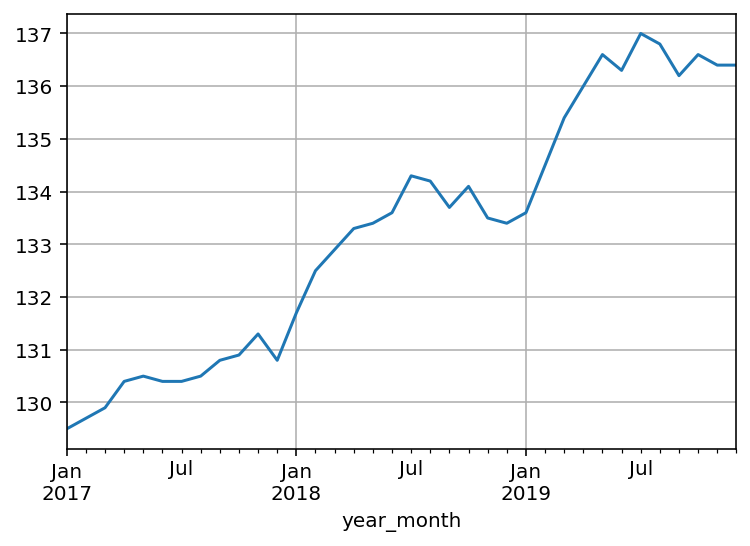

In [19]:
plt.figure()
df.CPI.plot(grid=True)

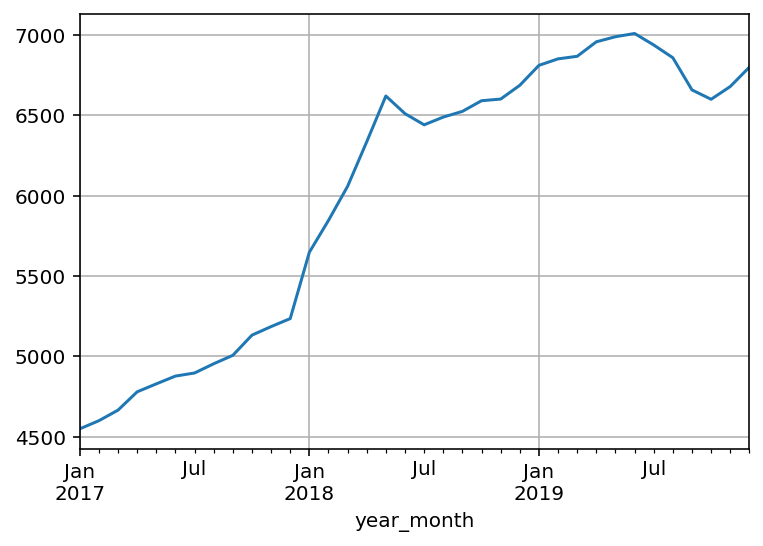

In [20]:
plt.figure()
df.occupancy.plot(grid=True)

Text(0.5, 1.0, 'Shelter Occupancy vs CPI')

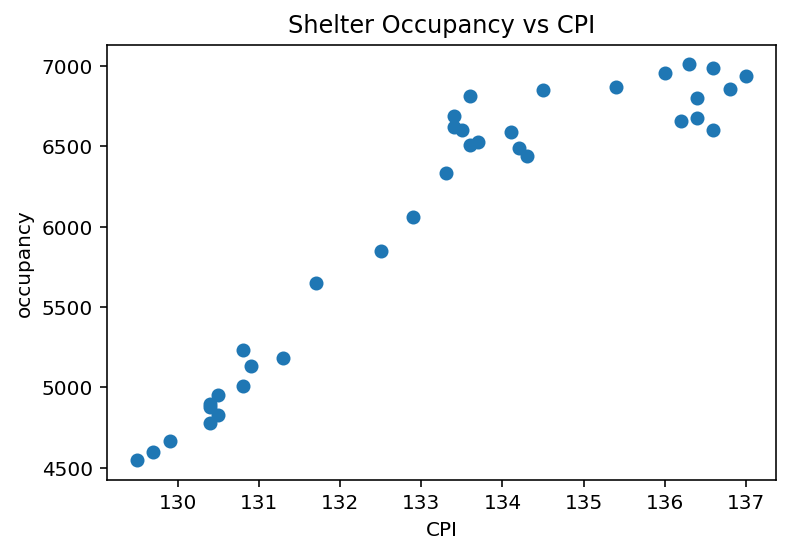

In [21]:
df2 = df.reset_index()
data = df2[['occupancy', 'CPI']]
plt.plot(data.CPI, data.occupancy, 'o', label = 'Observations')
plt.xlabel('CPI')
plt.ylabel('occupancy')
plt.title('Shelter Occupancy vs CPI')

Text(0.5, 1.0, 'Shelter Occupancy vs transformed CPI')

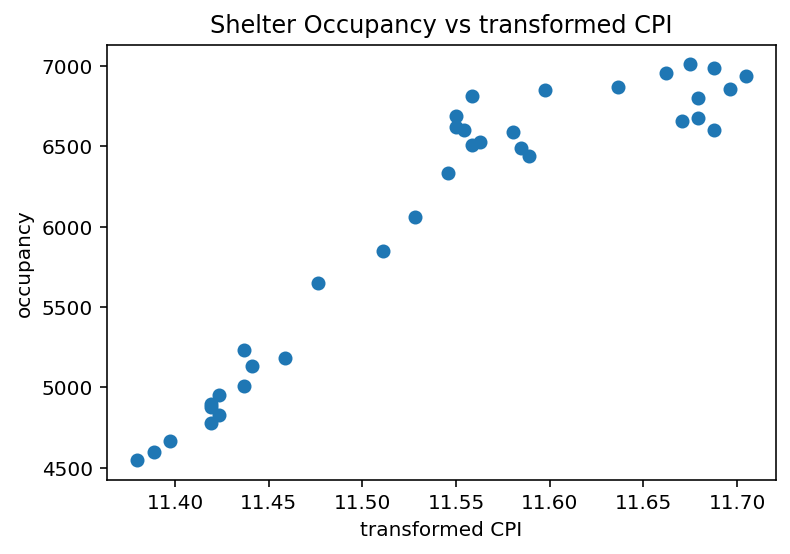

In [22]:
data['xform'] = data['CPI']**.5
#data['xform'] = np.log(data['CPI'])
plt.plot(data.xform, data.occupancy, 'o', label = 'Observations')
plt.xlabel('transformed CPI')
plt.ylabel('occupancy')
plt.title('Shelter Occupancy vs transformed CPI')

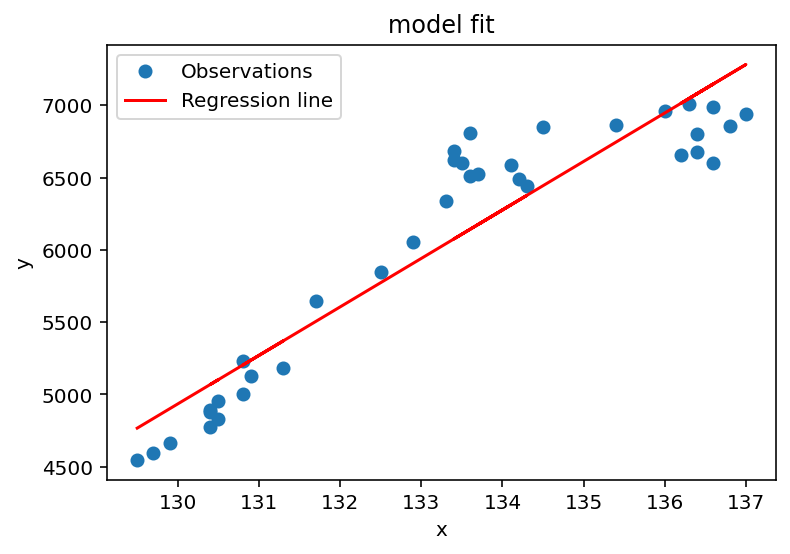

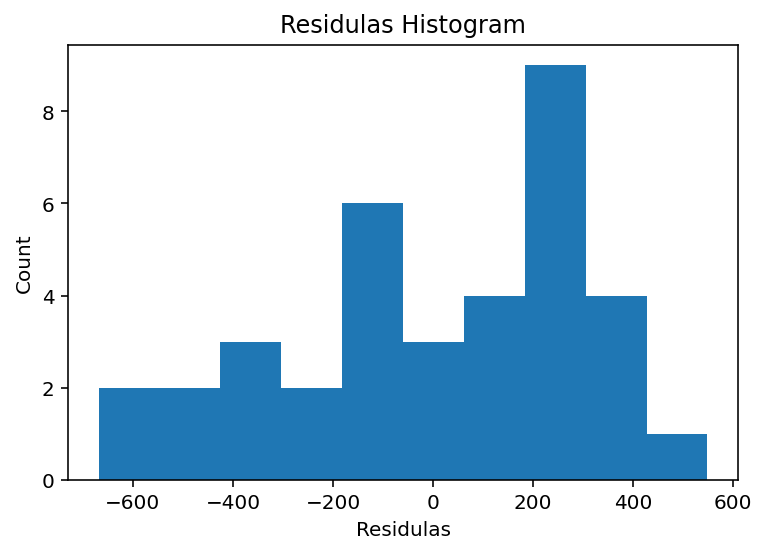

Model Residuals
count    3.600000e+01
mean    -1.952887e-11
std      3.149688e+02
min     -6.684421e+02
25%     -1.830398e+02
50%      7.202937e+01
75%      2.359488e+02
max      5.486369e+02
Name: Residuals, dtype: float64
                            OLS Regression Results                            
Dep. Variable:              occupancy   R-squared:                       0.869
Model:                            OLS   Adj. R-squared:                  0.866
Method:                 Least Squares   F-statistic:                     226.5
Date:                Thu, 30 Jul 2020   Prob (F-statistic):           1.34e-16
Time:                        19:02:22   Log-Likelihood:                -257.66
No. Observations:                  36   AIC:                             519.3
Df Residuals:                      34   BIC:                             522.5
Df Model:                           1                                         
Covariance Type:            nonrobust                            

In [23]:
m = sm.ols('occupancy ~ CPI', data = data)
m = m.fit()
intercept, slope = m.params
data['y_est'] = intercept + slope * data.CPI

# Calculate the residuals
data['Residuals'] = data['y_est'] - data['occupancy']

plt.plot(data.CPI, data.occupancy, 'o', label = 'Observations')
plt.xlabel('x')
plt.ylabel('y')
plt.title('model fit')

# Plot regression line
plt.plot(data.CPI, data.y_est, 'r-', label='Regression line')

# Add legend
plt.legend()
plt.show()

# We will plot the histogram of the residuals first
plt.hist(data.Residuals)

# Add axes labels
plt.xlabel('Residulas')
plt.ylabel('Count')
plt.title('Residulas Histogram')
plt.show()

# And we will print the statistical summary of the residuals,
# i.e. (median, mean, quartiles, etc.)
print('Model Residuals')
print(data['Residuals'].describe())
print('=========================')
# Print model summary 
print(m.summary())